In [1]:
import torch
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms import v2
import torch.nn.functional as F

In [2]:
import random
import numpy as np

seed = 10  # You can use any integer value as the seed

# Python random module
random.seed(seed)

# NumPy
np.random.seed(seed)

# PyTorch
torch.manual_seed(seed)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))    # To shift each pixel's value between -1 and 1, helping avoid exploding and vanishing gradients
])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.2),   # Randomly flip about 20% images horizontally, to help model learn right-left symmetry
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),   # To shift each pixel's value between [-1, 1], helping avoid exploding and vanishing gradients
])

In [5]:

train_dir = './cinic10/train'  
test_dir = './cinic10/test'
val_dir ='./cinic10/valid'

batch_size = 32

trainset = datasets.ImageFolder(root=train_dir, transform=train_transform)

trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.ImageFolder(root=test_dir, transform=transform)

testloader = DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

valset = datasets.ImageFolder(root=val_dir, transform=transform)

valloader = DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class FixedNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers with doubled output channels
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # Input: 3 channels, Output: 32 channels, 3x3 kernel, padding=1
        self.bn1 = nn.BatchNorm2d(32)  # BatchNorm for conv1 output
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling with 2x2 kernel
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # Input: 32 channels, Output: 64 channels, 3x3 kernel, padding=1
        self.bn2 = nn.BatchNorm2d(64)  # BatchNorm for conv2 output
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  # Input: 64 channels, Output: 128 channels, 3x3 kernel, padding=1
        self.bn3 = nn.BatchNorm2d(128)  # BatchNorm for conv3 output
        self.fc1 = nn.Linear(128 * 4 * 4, 120)  # Adjusted for new dimensions
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Output: 32 channels, 16x16
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Output: 64 channels, 8x8
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Output: 128 channels, 4x4
        x = torch.flatten(x, 1)  
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  

        return x

# Initialize the model
net = FixedNet()


In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# Initialize lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(10):  # loop over the dataset multiple times
    net.train()  # Set model to training mode
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            train_loss = running_loss / 2000
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {train_loss:.3f}')
            train_losses.append(train_loss)  # Save training loss
            running_loss = 0.0

            # Run validation at the same interval
            net.eval()  # Set model to evaluation mode
            val_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for data in valloader:
                    inputs, labels = data
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            # Calculate validation loss and accuracy
            val_loss /= len(valloader)
            val_accuracy = 100 * correct / total

            # Save validation metrics
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            print(f'Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.2f}%')

    # End of epoch
    print(f'Epoch {epoch + 1} finished')

# Save the model
PATH = './cinic_net_final.pth'
torch.save(net.state_dict(), PATH)

# Save the metrics for visualization
import pickle
with open('training_metrics.pkl', 'wb') as f:
    pickle.dump({
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }, f)

print('Finished Training and Saved Metrics')

[1,  2000] loss: 1.020
Validation Loss: 1.004, Validation Accuracy: 64.08%
Epoch 1 finished
[2,  2000] loss: 0.984
Validation Loss: 1.003, Validation Accuracy: 63.95%
Epoch 2 finished
[3,  2000] loss: 0.954
Validation Loss: 0.966, Validation Accuracy: 65.33%
Epoch 3 finished
[4,  2000] loss: 0.931
Validation Loss: 0.972, Validation Accuracy: 65.24%
Epoch 4 finished
[5,  2000] loss: 0.905
Validation Loss: 0.953, Validation Accuracy: 65.85%
Epoch 5 finished
[6,  2000] loss: 0.870
Validation Loss: 0.924, Validation Accuracy: 66.92%
Epoch 6 finished
[7,  2000] loss: 0.855
Validation Loss: 0.926, Validation Accuracy: 66.87%
Epoch 7 finished
[8,  2000] loss: 0.838
Validation Loss: 0.943, Validation Accuracy: 66.21%
Epoch 8 finished
[9,  2000] loss: 0.818
Validation Loss: 0.913, Validation Accuracy: 67.37%
Epoch 9 finished
[10,  2000] loss: 0.802
Validation Loss: 0.894, Validation Accuracy: 68.20%
Epoch 10 finished
Finished Training and Saved Metrics


In [19]:
with open('training_metrics.pkl', 'rb') as f:
    metrics = pickle.load(f)

print(metrics)

{'train_losses': [1.0196912645697593, 0.984169227823615, 0.9540812044888735, 0.9311304796040059, 0.9047374472171068, 0.8703318593651056, 0.8552738332003355, 0.8375500105172395, 0.817721051350236, 0.8024696322828532], 'val_losses': [1.0037879374525829, 1.002976341551144, 0.9660388817126709, 0.9724334378260291, 0.9534576569882166, 0.9239297306375003, 0.9259431376580481, 0.9429299679505011, 0.9128137722418078, 0.8941730144415468], 'val_accuracies': [64.08111111111111, 63.952222222222225, 65.33444444444444, 65.23777777777778, 65.85, 66.91777777777777, 66.86666666666666, 66.21, 67.37, 68.2]}


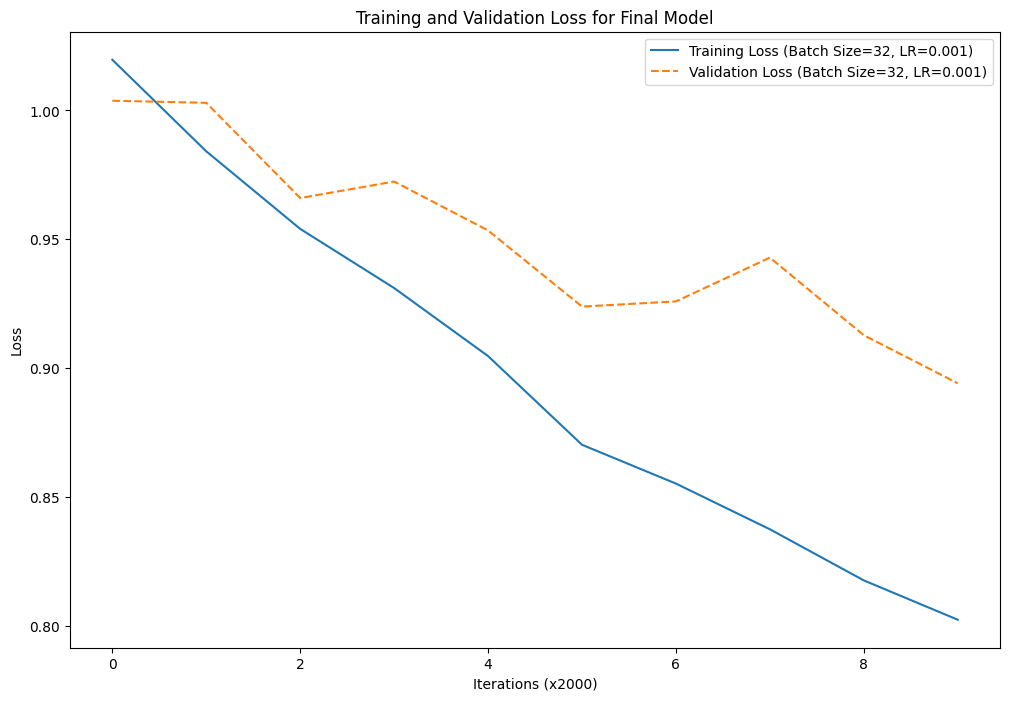

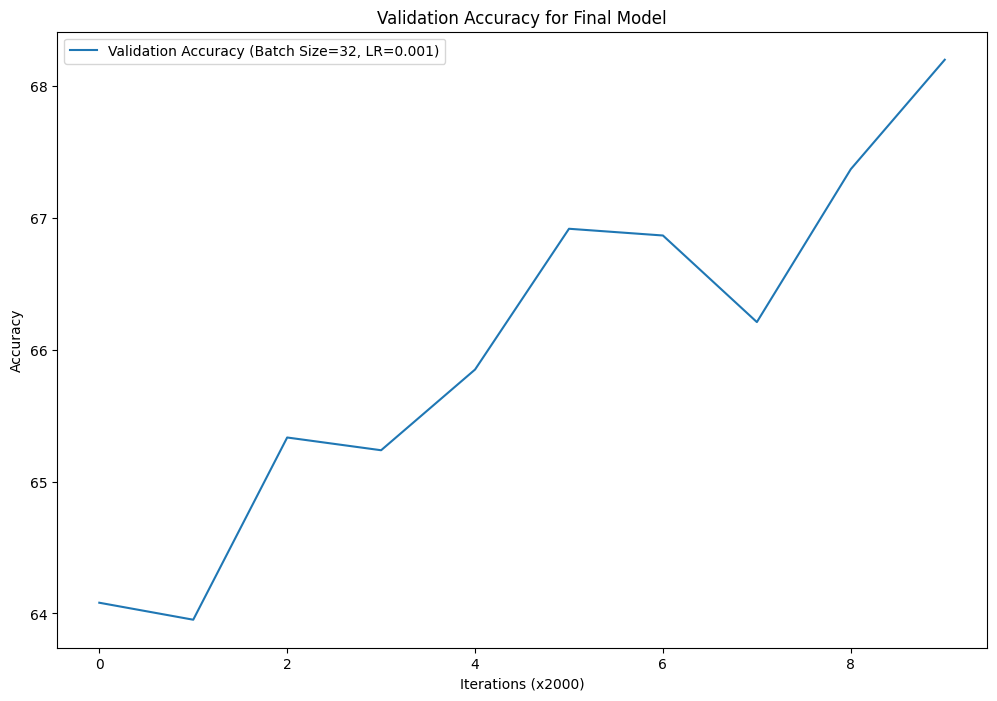

In [21]:
results =[
   {'batch_size': 32,
    'learning_rate': 0.001,
       'train_losses': [1.0196912645697593, 0.984169227823615, 0.9540812044888735, 0.9311304796040059, 0.9047374472171068, 0.8703318593651056, 0.8552738332003355, 0.8375500105172395, 0.817721051350236, 0.8024696322828532], 
    'val_losses': [1.0037879374525829, 1.002976341551144, 0.9660388817126709, 0.9724334378260291, 0.9534576569882166, 0.9239297306375003, 0.9259431376580481, 0.9429299679505011, 0.9128137722418078, 0.8941730144415468], 
    'val_accuracies': [64.08111111111111, 63.952222222222225, 65.33444444444444, 65.23777777777778, 65.85, 66.91777777777777, 66.86666666666666, 66.21, 67.37, 68.2]
    }
]
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(12, 8))
for result in results:
    label = f'Batch Size={result["batch_size"]}, LR={result["learning_rate"]}'

    # Plot training losses
    plt.plot(result["train_losses"], label=f"Training Loss ({label})")

    # Plot validation losses
    plt.plot(result["val_losses"], "--", label=f"Validation Loss ({label})")

plt.xlabel("Iterations (x2000)")
plt.ylabel("Loss")
plt.title("Training and Validation Loss for Final Model")
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(12, 8))
for result in results:
    label = f'Batch Size={result["batch_size"]}, LR={result["learning_rate"]}'

    # Plot validation accuracies
    plt.plot(result["val_accuracies"], label=f"Validation Accuracy ({label})")

plt.xlabel("Iterations (x2000)")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy for Final Model")
plt.legend()
plt.show()

In [22]:
import torch
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

freq_bins = 128  
time_steps = 16000  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FixedNet()

model.load_state_dict(
    torch.load("cinic_net_final.pth")
)
print("the model is loaded")
model.eval()

all_labels = []
all_predictions = []

occurence = 0
with torch.no_grad():
    length = len(testloader)
    for inputs, labels in testloader:
        print(f"start testing occurence {occurence + 1}/{length}")
        occurence += 1
        inputs, labels = inputs.to(device), labels.to(device)

        
        outputs = model(inputs)
        _, predicted = torch.max(
            outputs, 1
        )  
        all_labels.extend(labels.cpu().numpy())  
        all_predictions.extend(predicted.cpu().numpy())

f1 = f1_score(all_labels, all_predictions, average="macro")
precision = precision_score(all_labels, all_predictions, average="macro")
recall = recall_score(all_labels, all_predictions, average="macro")
accuracy = accuracy_score(all_labels, all_predictions)

# Print metrics
print(f"F1-Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")

C:\Users\elenm\AppData\Local\Temp\ipykernel_22816\1945623652.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("cinic_net_final.pth")


the model is loaded
start testing occurence 1/2813
start testing occurence 2/2813
start testing occurence 3/2813
start testing occurence 4/2813
start testing occurence 5/2813
start testing occurence 6/2813
start testing occurence 7/2813
start testing occurence 8/2813
start testing occurence 9/2813
start testing occurence 10/2813
start testing occurence 11/2813
start testing occurence 12/2813
start testing occurence 13/2813
start testing occurence 14/2813
start testing occurence 15/2813
start testing occurence 16/2813
start testing occurence 17/2813
start testing occurence 18/2813
start testing occurence 19/2813
start testing occurence 20/2813
start testing occurence 21/2813
start testing occurence 22/2813
start testing occurence 23/2813
start testing occurence 24/2813
start testing occurence 25/2813
start testing occurence 26/2813
start testing occurence 27/2813
start testing occurence 28/2813
start testing occurence 29/2813
start testing occurence 30/2813
start testing occurence 31/28

In [23]:
import torch
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import numpy as np

# Define the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the model
model =FixedNet().to(device)  # Move the model to the appropriate device
model.load_state_dict(torch.load("cinic_net_final.pth"))
print("The model is loaded")

# Set the model to evaluation mode
model.eval()


# Initialize counters for per-class accuracy
num_classes = 10  # Replace with the number of classes in your dataset
class_correct = np.zeros(num_classes)
class_total = np.zeros(num_classes)

# Lists to store all labels and predictions
all_labels = []
all_predictions = []

# Test the model
with torch.no_grad():
    length = len(testloader)
    for i, (inputs, labels) in enumerate(testloader):
        print(f"Testing batch {i + 1}/{length}")
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # Store all labels and predictions for overall metrics
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        # Update per-class accuracy counters
        for j in range(len(labels)):
            label = labels[j].item()
            pred = predicted[j].item()
            class_total[label] += 1
            if label == pred:
                class_correct[label] += 1

# Calculate overall metrics
f1 = f1_score(all_labels, all_predictions, average="macro")
precision = precision_score(all_labels, all_predictions, average="macro")
recall = recall_score(all_labels, all_predictions, average="macro")
accuracy = accuracy_score(all_labels, all_predictions)

# Print overall metrics
print(f"F1-Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Calculate and print per-class accuracy
print("\nPer-Class Accuracy:")
for i in range(num_classes):
    if class_total[i] > 0:
        class_accuracy = class_correct[i] / class_total[i]
        print(
            f"Class {i}: {class_accuracy:.4f} (Correct: {int(class_correct[i])}, Total: {int(class_total[i])})"
        )
    else:
        print(f"Class {i}: No samples found")

Using device: cpu
The model is loaded


C:\Users\elenm\AppData\Local\Temp\ipykernel_22816\2663015036.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cinic_net_final.pth"))


Testing batch 1/2813
Testing batch 2/2813
Testing batch 3/2813
Testing batch 4/2813
Testing batch 5/2813
Testing batch 6/2813
Testing batch 7/2813
Testing batch 8/2813
Testing batch 9/2813
Testing batch 10/2813
Testing batch 11/2813
Testing batch 12/2813
Testing batch 13/2813
Testing batch 14/2813
Testing batch 15/2813
Testing batch 16/2813
Testing batch 17/2813
Testing batch 18/2813
Testing batch 19/2813
Testing batch 20/2813
Testing batch 21/2813
Testing batch 22/2813
Testing batch 23/2813
Testing batch 24/2813
Testing batch 25/2813
Testing batch 26/2813
Testing batch 27/2813
Testing batch 28/2813
Testing batch 29/2813
Testing batch 30/2813
Testing batch 31/2813
Testing batch 32/2813
Testing batch 33/2813
Testing batch 34/2813
Testing batch 35/2813
Testing batch 36/2813
Testing batch 37/2813
Testing batch 38/2813
Testing batch 39/2813
Testing batch 40/2813
Testing batch 41/2813
Testing batch 42/2813
Testing batch 43/2813
Testing batch 44/2813
Testing batch 45/2813
Testing batch 46/28